### <b> Feature engineering exploration </b> notebook for AmesHousingPrices
by Martijn de Vries </br>
martijndevries91@gmail.com <br>
http://github.com/martijndevries/AmesHousingPrices

## Problem Statement

A real estate company in Ames, Iowa is looking for a new and improved way to evaluate the market value of a house. Using the Ames data set as training data, I will build a predictive linear regression model to predict the sale price of a house.

To gauge the model performance, I will compare my results against a 'benchmark model', which is a simple OLS regression of total living area versus sale price. How much can a more complex model improve over this simple basic model? I will try out different models with different numbers of features using different linear regression techniques, and ultimately identify which model does the best job at predicting the market value of the house. To evaluate and compare models, I will use the r2-score, as well as the root mean squared error (RMSE). 

## In this notebook

I will investigate which features correlate well with Saleprice and might be included in the model. I will also feature engineer a few new features.
The idea is to start from the ground up, and to build several models with gradually increase model complexity.

This notebook is used for exploration and visualization purposes. The functions to directly feature engineer the cleaned data  can be found in the main feature engineering notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sys

In [2]:
df_train = pd.read_csv('../datasets/train_cleaned.csv', dtype={'MS SubClass':'object'})

### Feature engineering for Model 1

Let's start with numerical features and see which ones are the most correlated with sale price, to get an idea which ones would be the most important to include.

In [3]:
for col in df_train.columns:
    if df_train[col].dtype != 'object':
        print(col)

Id
Lot Frontage
Lot Area
Overall Qual
Overall Cond
Year Built
Year Remod/Add
Mas Vnr Area
BsmtFin SF 1
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
1st Flr SF
2nd Flr SF
Low Qual Fin SF
Gr Liv Area
Bsmt Full Bath
Bsmt Half Bath
Full Bath
Half Bath
Bedroom AbvGr
Kitchen AbvGr
TotRms AbvGrd
Fireplaces
Garage Yr Blt
Garage Cars
Garage Area
Wood Deck SF
Open Porch SF
Enclosed Porch
3Ssn Porch
Screen Porch
Pool Area
Misc Val
Mo Sold
Yr Sold
SalePrice


Now let's use a heatmap to see how these features correlate with sale price

/var/folders/w4/w_knz6hd3w7gjmkp2lg297yr0000gr/T/ipykernel_96961/163237986.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)[:19], cmap='coolwarm', vmin=-1, vmax=1, annot=True, ax=ax1);
/var/folders/w4/w_knz6hd3w7gjmkp2lg297yr0000gr/T/ipykernel_96961/163237986.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)[19:], cmap='coolwarm', vmin=-1, vmax=1, annot=True, ax=ax2);


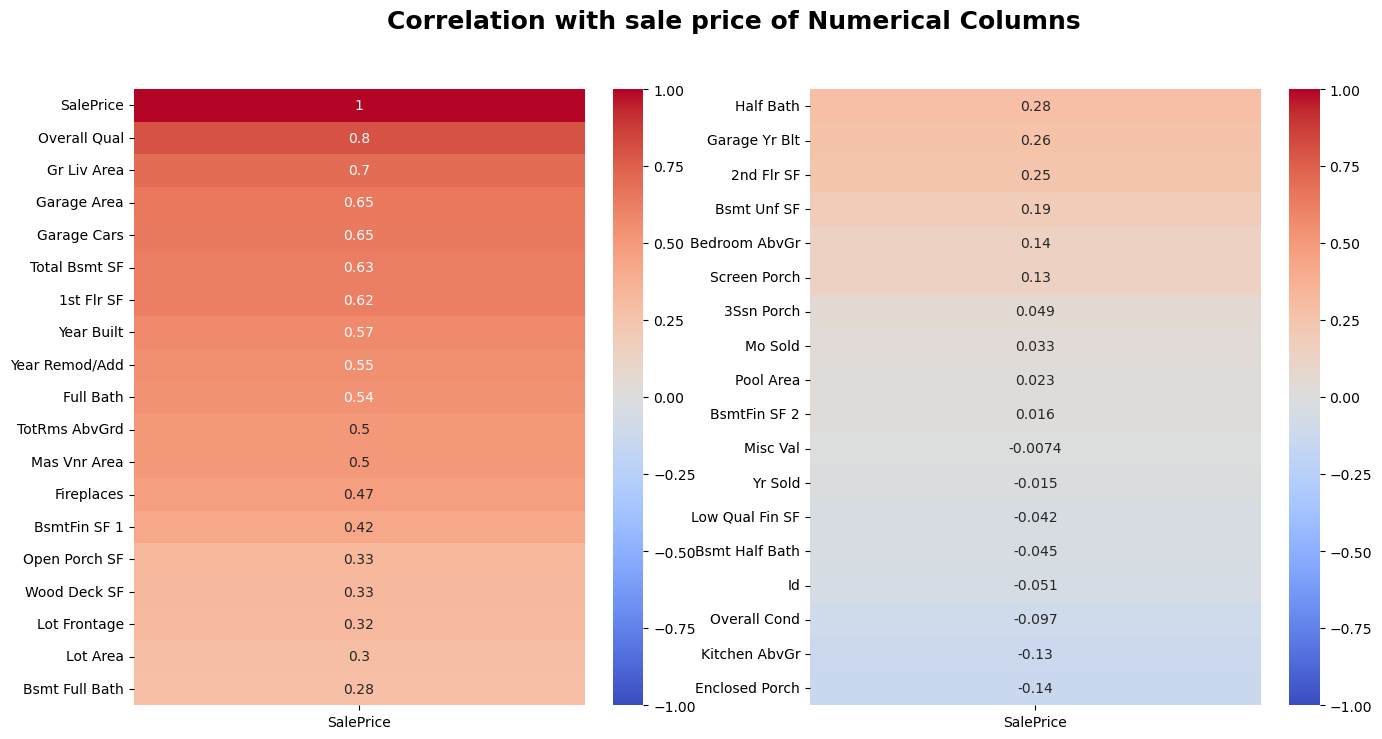

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(df_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)[:19], cmap='coolwarm', vmin=-1, vmax=1, annot=True, ax=ax1);
sns.heatmap(df_train.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)[19:], cmap='coolwarm', vmin=-1, vmax=1, annot=True, ax=ax2);
#set a title for the entire figure, not the individual subplots
fig.suptitle('Correlation with sale price of Numerical Columns', fontsize=18, fontweight='bold')
plt.savefig('../figures/saleprice_corr_heatmap.png')

It seems there are a few numerical features that strongly correlate with sale price, great.

Some related features could probably be combined to make the model more simple. Let's start with living area - we can just make a new parameter 'tot_area' that sums the above grade living area ('Gr Liv Area'), and the basement area ('Total Bsmt SF').

First, let's see how well these features are correlated (ie does it make sense to combine them?)

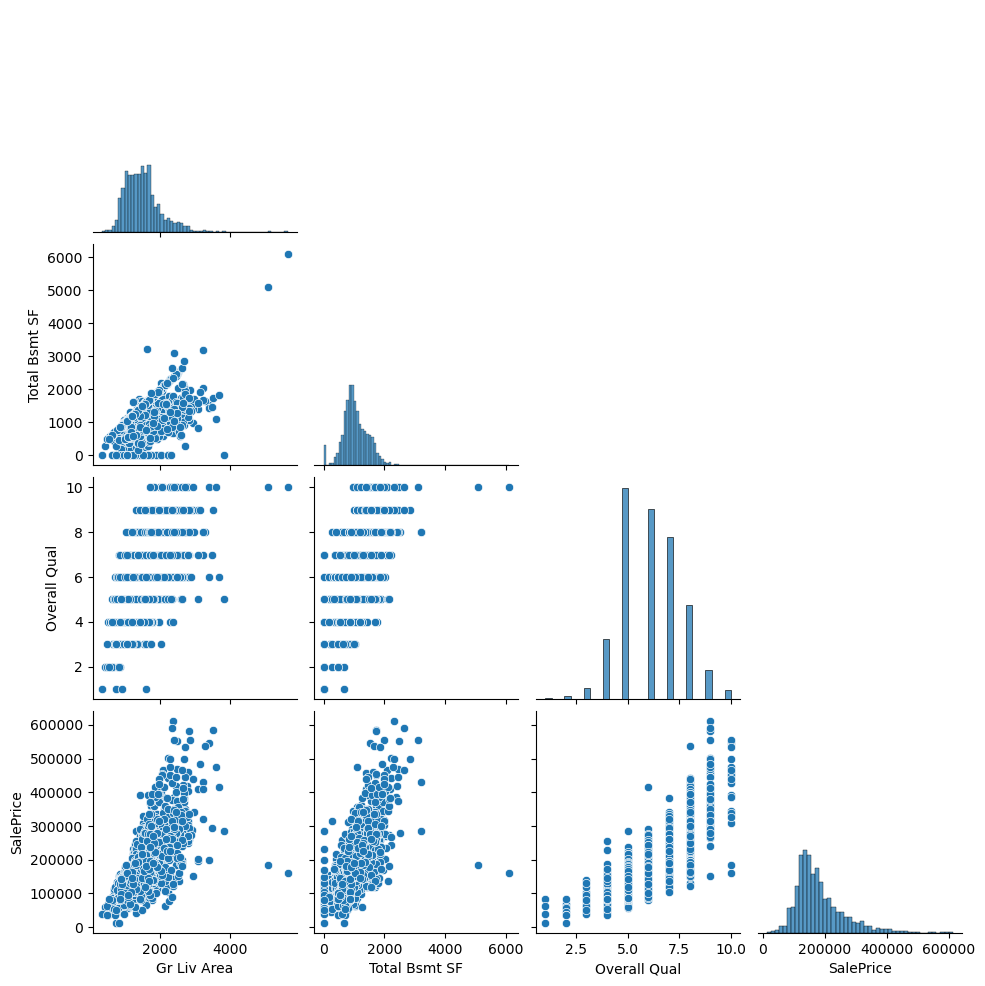

In [5]:
area_features = ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'SalePrice']
sns.pairplot(df_train[area_features], corner=True);

Yup, they are clearly correlated and seem to relate to the sale price in similar ways. There are two outliers that do look pretty suspicious: the two houses in the dataset with the largest above-grade living area, and massive basement space to boot, plus an excellent quality rating, sold for only around 170k dollars. What's going on here?

In [6]:
cols = ['Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'Functional', 'MS Zoning',  'MS SubClass', 'SalePrice']
df_train[df_train['Gr Liv Area'] > 4000][cols]

,Gr Liv Area,Total Bsmt SF,Overall Qual,Functional,MS Zoning,MS SubClass,SalePrice
960,5642,6110.0,10,Typ,RL,060,160000
1885,5095,5095.0,10,Typ,RL,020,183850


Nothing stand out in the columns that I can think of checking out - these places are sold for residential living, have an excellent quality rating, and have a 'typical' functionality rating. I'm wondering if there might some kind of data entry error here. For house 1885, it seems like a big coincidence that the square footage for above and below ground is the exact same. 
Either way - these outliers are egregious enough, that we should just get rid of them I think

In [7]:
inds = df_train[df_train['Gr Liv Area'] > 4000][cols].index
df_train.drop(index=inds, inplace=True)

In [8]:
df_train['tot_area'] = df_train['Gr Liv Area']  + df_train['Total Bsmt SF']

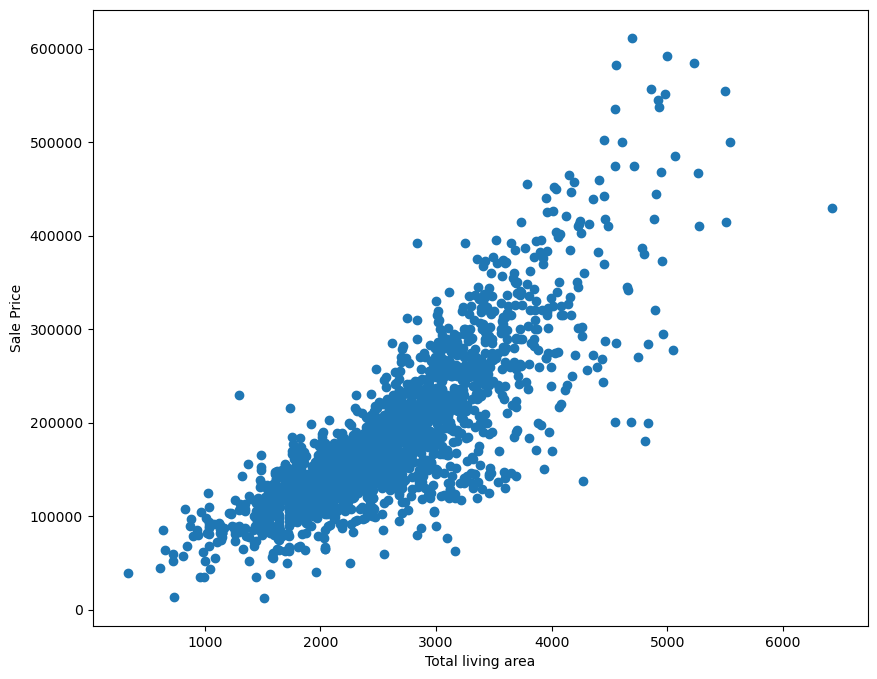

In [9]:
#how does this new variable correlate with sale price?
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_train['tot_area'], df_train['SalePrice'])
ax.set_xlabel('Total living area')
ax.set_ylabel('Sale Price')
plt.show()

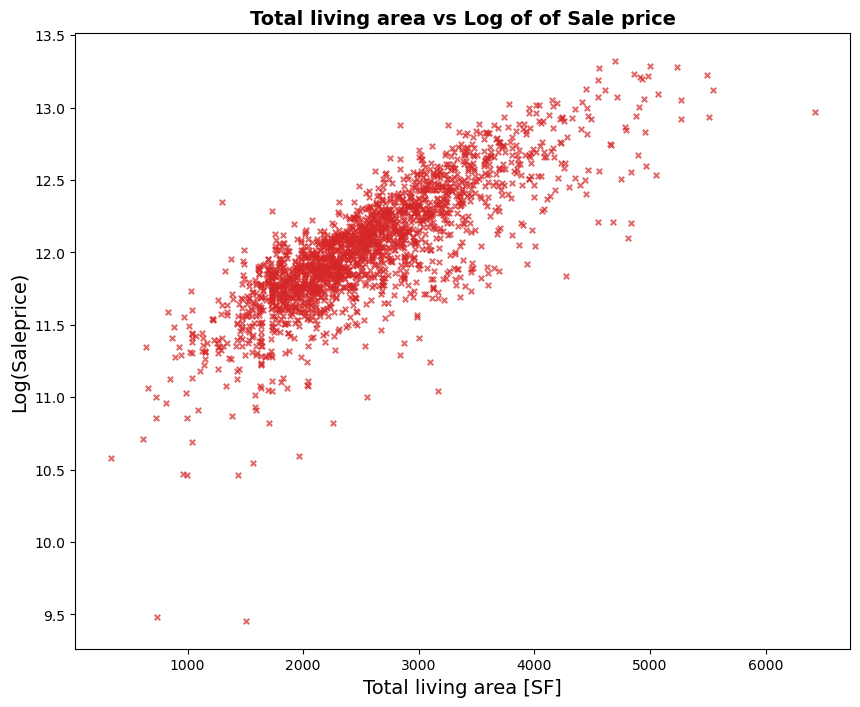

In [10]:
#how does this new variable correlate with log sale price?
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_train['tot_area'], np.log(df_train['SalePrice']), marker='x', s=15, alpha=0.7, color='tab:red')
ax.set_xlabel('Total living area [SF]', fontsize=14)
ax.set_ylabel('Log(Saleprice)', fontsize=14)
ax.set_title('Total living area vs Log of of Sale price', fontsize=14, fontweight='bold')
plt.savefig('../figures/area_log_saleprice.png', dpi=300)
plt.show()

One other thing that stands out to me is the very low correlation between overall condition and the sale price. You would expect it would relate to Sale price in a similar way as 'Overall Qual' does.

In [11]:
df_train['Overall Cond'].value_counts()

5    1166
6     368
7     270
8     101
4      70
3      35
9      29
2       6
1       4
Name: Overall Cond, dtype: int64

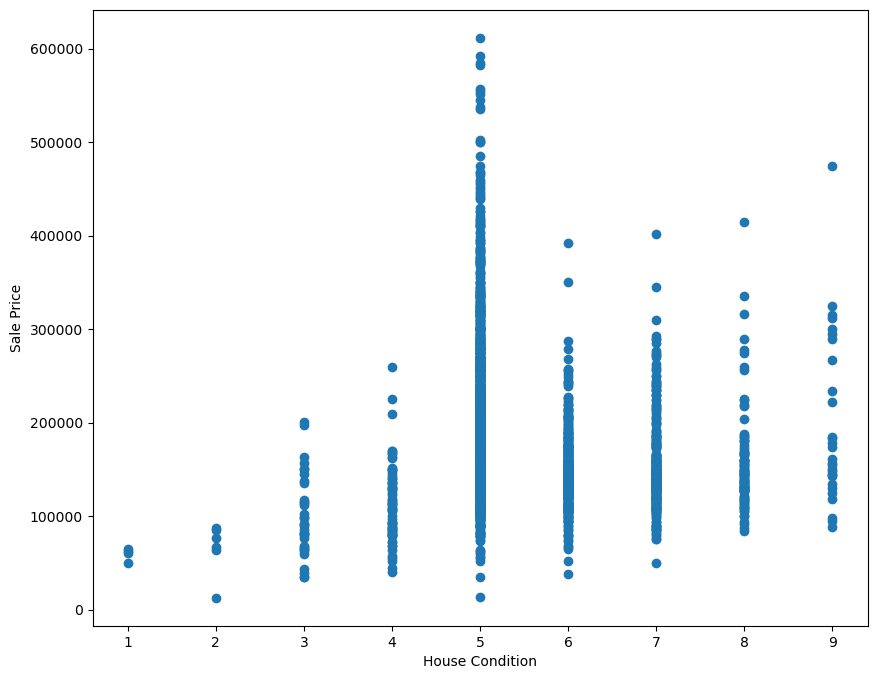

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(df_train['Overall Cond'], df_train['SalePrice'])
ax.set_xlabel('House Condition')
ax.set_ylabel('Sale Price')
plt.show()

Houses with a condition rated '5' have the widest distribution of sale prices, which might be throwing the model off and is what probably leads to that low correlation coefficient. Let's hold off on including it in the simple model.

Next: there are a lot of columns related to the Garage. We could come up with a way to condense this information, perhaps into a single 'garage rating' parameter or something like that. From the correlation heatmap above, it seems that 'Garage area' correlates highly with saleprice. So perhaps we should use that as a starting point, and modulate that value based on a few other things garage qualities

In [13]:
gar_cols = [col for col in df_train.columns if 'Garage' in col]
df_train[gar_cols].head()

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
0,Attchd,1976.0,RFn,2,475.0,TA,TA
1,Attchd,1997.0,RFn,2,559.0,TA,TA
2,Detchd,1953.0,Unf,1,246.0,TA,TA
3,BuiltIn,2007.0,Fin,2,400.0,TA,TA
4,Detchd,1957.0,Unf,2,484.0,TA,TA


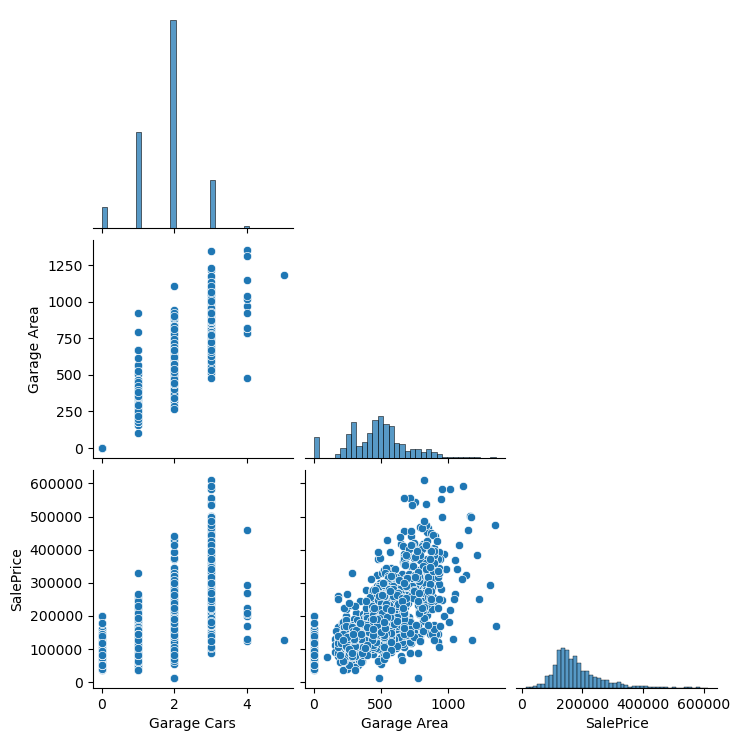

In [14]:
#Let's make a pair plot for the 3 numerical values here
gar_num_features = ['Garage Cars', 'Garage Area', 'SalePrice']
sns.pairplot(df_train[gar_num_features], corner=True);

I think that 'Garage Cars' and 'Garage Area' are correlated enough (bigger garage = more cars), that leaving out 'Garage Cars' is not a very big deal - most of that information is already contained in 'Garage Area'.

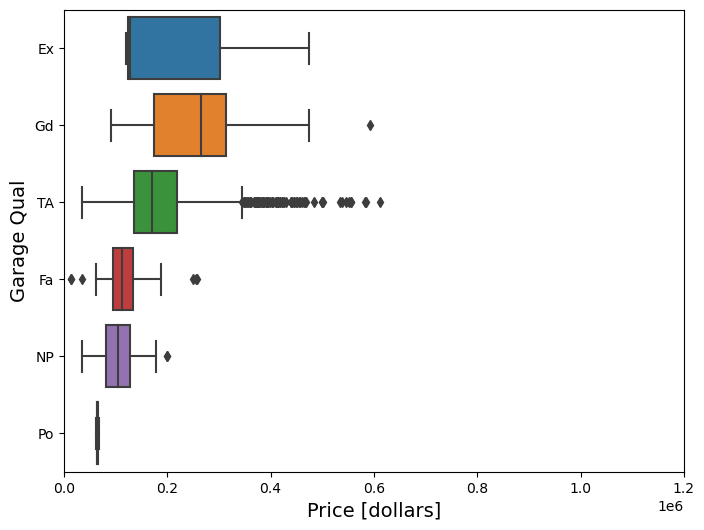

TA    1831
NP     113
Fa      82
Gd      18
Ex       3
Po       2
Name: Garage Qual, dtype: int64

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_train, x="SalePrice", y="Garage Qual",order=['Ex', 'Gd', 'TA', 'Fa', 'NP', 'Po'])
ax.set_xlabel('Price [dollars]', fontsize=14)
ax.set_ylabel('Garage Qual', fontsize=14)
ax.set_xlim(0, 1.2e6)  
plt.show()

df_train['Garage Qual'].value_counts()

How can we use this to modulate the area? We could do the following: 
1) Obtain the increase/decrease in house sale price for each Garage category, relative to having no garage
2) Use those average increase/decrease to modulate the garage area

In [16]:
#get mean house sale price for each garage category
df_grouped = df_train.groupby(by="Garage Qual")['SalePrice'].mean()
bad_to_good = ['Po', 'NP', 'Fa', 'TA', 'Gd', 'Ex']
df_grouped = df_grouped.reindex(bad_to_good)
df_grouped

Garage Qual
Po     65000.000000
NP    105669.150442
Fa    116184.890244
TA    188310.172583
Gd    262989.277778
Ex    241000.000000
Name: SalePrice, dtype: float64

Then we set the benchmark at garages with a TA rating

In [17]:
df_grouped -= df_grouped['NP']
gar_qual_coefs = df_grouped/df_grouped['TA']
print(gar_qual_coefs)

Garage Qual
Po   -0.492118
NP    0.000000
Fa    0.127246
TA    1.000000
Gd    1.903657
Ex    1.637575
Name: SalePrice, dtype: float64


Great! We can use these coefficients and multiply them with the garage area to get some abstract representation of how much the garage is worth. Remember we are building a predictive model, not an inferential one - so I don't care too much about the interpretability of the features.

What about Garage Condition? My first thought is that there is likely to be a lot of overlap between Garage 'Quality' and 'Condition'. Let's check this

In [18]:
df_train.loc[df_train['Garage Qual'] != df_train['Garage Cond'], ['Garage Qual', 'Garage Cond']]

,Garage Qual,Garage Cond
43,Fa,TA
45,Fa,TA
77,Fa,TA
175,TA,Fa
183,Fa,Po
...,...,...
1961,Fa,TA
1964,Gd,TA
1974,Gd,TA
2028,Gd,TA


Only 96 rows, and in most cases the difference is only one rank (ie between Typical and Fair). So I'm going to ignore this one.

For Garage Type, I will follow the same procedure as for Garage Qual

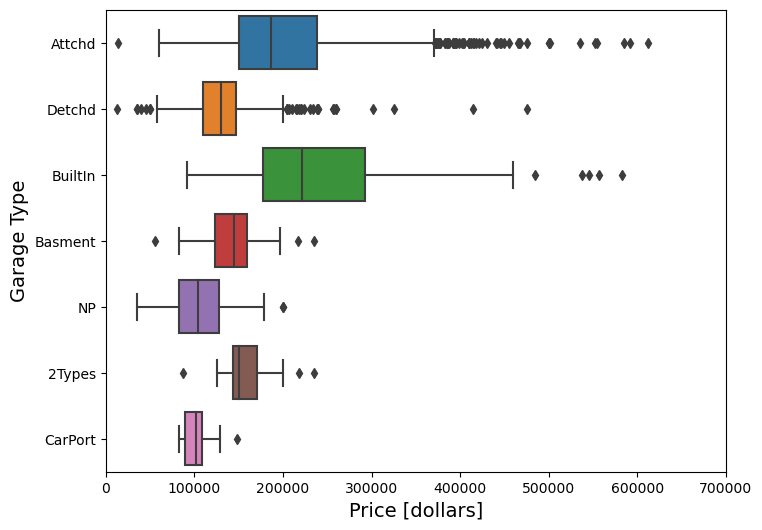

Attchd     1211
Detchd      536
BuiltIn     132
NP          113
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_train, x="SalePrice", y="Garage Type")
ax.set_xlabel('Price [dollars]', fontsize=14)
ax.set_ylabel('Garage Type', fontsize=14)
ax.set_xlim(0, 7e5)  
plt.show()
df_train['Garage Type'].value_counts()

In [20]:
df_grouped = df_train.groupby(by="Garage Type")['SalePrice'].mean()
#df_grouped = df_grouped.reindex(bad_to_good)
df_grouped -= df_grouped['NP']
gar_type_coefs = df_grouped / df_grouped['Attchd']
gar_type_coefs

Garage Type
2Types     0.518126
Attchd     1.000000
Basment    0.377902
BuiltIn    1.430358
CarPort   -0.018563
Detchd     0.266166
NP         0.000000
Name: SalePrice, dtype: float64

In [21]:
def calc_gar_adj(row, type_coefs, qual_coefs):
    """
    calculate adjusted garage area based on 
    1) the actual square footage
    2) the garage quality
    3) the garage type 
    the type_coefs and qual_coefs should be pandas series, so that I can look up the appropriate coefficient based on input quality and type
    """
    gtype = row['Garage Type']
    area = row['Garage Area']
    gqual = row['Garage Qual']
    return area * (type_coefs[gtype] + qual_coefs[gqual])/2

In [22]:
#Using an actual for loop rather than map, because I don't know a better way to call a function with multiple arguments in .map() or .apply()
gar_adj_l = []
for rowind in df_train.index:
    row = df_train.loc[rowind]
    gar_adj_l.append(calc_gar_adj(row, gar_type_coefs, gar_qual_coefs))
df_train['gar_adj_area'] = gar_adj_l


<Axes: >

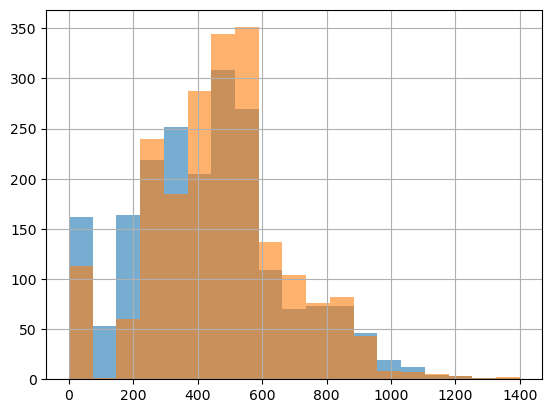

In [23]:
#Compare area and adjusted area
lbins = np.linspace(0, 1400, 20)
df_train['gar_adj_area'].hist(alpha=0.6, bins=lbins)
df_train['Garage Area'].hist(alpha=0.6, bins=lbins)

In [24]:
#Correlation between sales price and area vs adjusted area
print(df_train['SalePrice'].corr(df_train['gar_adj_area']))
print(df_train['SalePrice'].corr(df_train['Garage Area']))

0.756019906923017
0.655452474979582


What else do I want to incorporate in the model? Year Built and Year Remodeled seem like obvious candidates given their high correlation with Sale price - let's see what those pairplots look like:

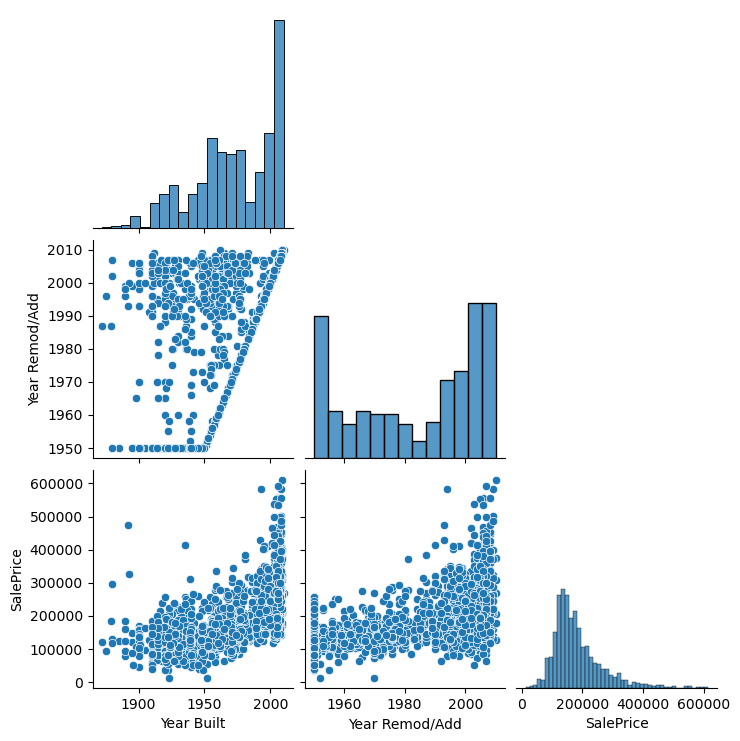

In [25]:
yr_features = ['Year Built', 'Year Remod/Add', 'SalePrice']
sns.pairplot(df_train[yr_features], corner=True);

Maybe a log transform would be more appropriate?

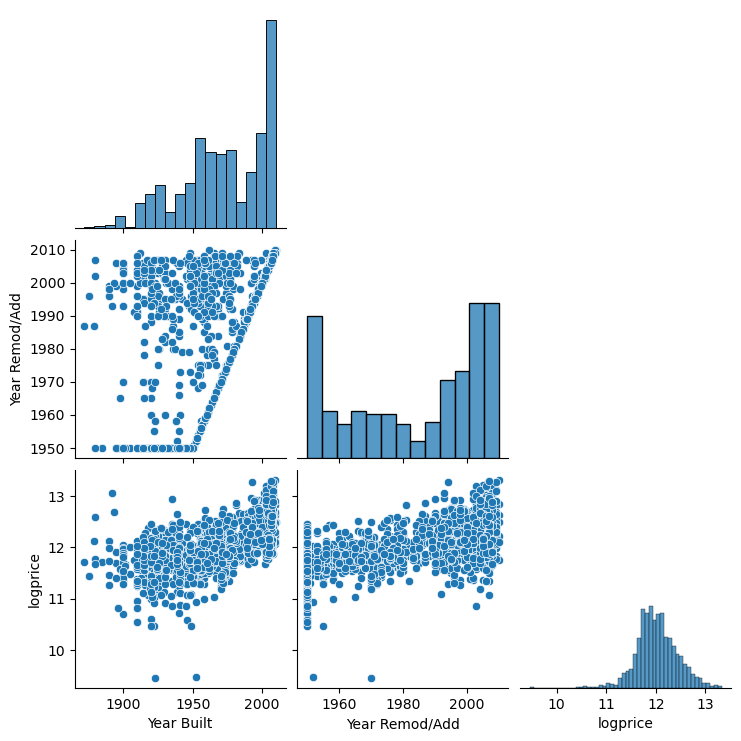

In [26]:
df_train['logprice'] = np.log(df_train['SalePrice'])
sns.pairplot(df_train[['Year Built', 'Year Remod/Add', 'logprice']], corner=True);

It seems that it might be! Although this introduces two new outliers. This might be an issue with using the log-transform in general: it might be difficult to predict saleprices that are much lower than average, because it's easier to end up with a big difference in logspace. Let's investigate these outliers

In [27]:
cols = ['Id','Gr Liv Area', 'Total Bsmt SF', 'Overall Qual', 'Functional', 'MS Zoning',  'MS SubClass', 'SalePrice']
df_train[df_train['logprice'] < 10][cols]

,Id,Gr Liv Area,Total Bsmt SF,Overall Qual,Functional,MS Zoning,MS SubClass,SalePrice
183,1554,733,0.0,1,Sal,A (agr),020,13100
1628,182,832,678.0,2,Typ,RM,030,12789


There seem to be good reasons for those prices, just looking at these columns... both properties are small, the housing quality is low. One noteworthy thing is that one of the buildings is zones for Agricultural use. Which 'MS Zoning' categories are in the test data?

In [28]:
df_test = pd.read_csv('../datasets/test_cleaned.csv', dtype={'MS SubClass':'object'})
df_test['MS Zoning'].value_counts()

RL         674
RM         146
FV          38
RH          13
C (all)      6
I (all)      1
Name: MS Zoning, dtype: int64

There aren't any agricultural zoned buildings in the test data - so maybe let's just get rid of the A (agr) entries in the training data. The category is not necessary to predict anything about the test data, there are only a few A (agr) properties to begin with, and it removes one of these annoying outliers.

In [29]:
agr_inds = df_train[df_train['MS Zoning'] == 'A (agr)'].index
df_train.drop(index=agr_inds, inplace=True)

For building ID 1628, maybe I will just inspect all columns and see if anything stands out that might explain the super low price

In [30]:
s = df_train.loc[1628]
for ind in s.index: print(ind, s[ind])

Id 182
MS SubClass 030
MS Zoning RM
Lot Frontage 68.0
Lot Area 9656
Street Pave
Alley NP
Lot Shape Reg
Land Contour Lvl
Utilities AllPub
Lot Config Inside
Land Slope Gtl
Neighborhood OldTown
Condition 1 Norm
Condition 2 Norm
Bldg Type 1Fam
House Style 1Story
Overall Qual 2
Overall Cond 2
Year Built 1923
Year Remod/Add 1970
Roof Style Gable
Roof Matl CompShg
Exterior 1st AsbShng
Exterior 2nd AsbShng
Mas Vnr Type None
Mas Vnr Area 0.0
Exter Qual TA
Exter Cond Fa
Foundation BrkTil
Bsmt Qual Fa
Bsmt Cond Fa
Bsmt Exposure No
BsmtFin Type 1 Unf
BsmtFin SF 1 0.0
BsmtFin Type 2 Unf
BsmtFin SF 2 0.0
Bsmt Unf SF 678.0
Total Bsmt SF 678.0
Heating GasA
Heating QC TA
Central Air N
Electrical SBrkr
1st Flr SF 832
2nd Flr SF 0
Low Qual Fin SF 0
Gr Liv Area 832
Bsmt Full Bath 0
Bsmt Half Bath 0
Full Bath 1
Half Bath 0
Bedroom AbvGr 2
Kitchen AbvGr 1
Kitchen Qual TA
TotRms AbvGrd 5
Functional Typ
Fireplaces 1
Fireplace Qu Gd
Garage Type Detchd
Garage Yr Blt 1928.0
Garage Finish Unf
Garage Cars 2
Garage

I can't see anything that stands out, other than that the house is in poor overall quality/condition and is quite old. But it does have a garage, utilities, electricity, was a normal sale, and so on. I will leave this datapoint in.

The above considerations do raise the question whether the 'Functional' column may be important to include:

In [31]:
df_train['Functional'].value_counts()

Typ     1913
Min2      42
Min1      42
Mod       28
Maj1      12
Maj2       7
Sev        2
Sal        1
Name: Functional, dtype: int64

In [32]:
df_train.groupby(by='Functional')['SalePrice'].mean()

Functional
Maj1    163106.166667
Maj2     87157.714286
Min1    154429.761905
Min2    150424.571429
Mod     150487.607143
Sal      50000.000000
Sev      95750.000000
Typ     183967.326189
Name: SalePrice, dtype: float64

It does seem like there's a big difference in pricing here. I'm trying to avoid creating too many columns, so I can make this a little coarser by combining categories: eg Min1 and Min2, Maj1 an and Maj2, Sev and Sal:

In [33]:
func_dic = {'Typ':'Typ', 'Min1':'Min', 'Min2':'Min', 'Mod':'Mod', 'Maj1':'Maj', 'Maj2':'Maj', 'Sev':'Sev', 'Sal':'Sev'}
df_train['Func'] = df_train['Functional'].map(lambda func: func_dic[func])
df_train['Func'].value_counts()

Typ    1913
Min      84
Mod      28
Maj      19
Sev       3
Name: Func, dtype: int64

Another categorical variable that might have a big effect is whetehr there is a pool or not, but if we do a value_counts:

In [34]:
df_train['Pool QC'].value_counts()

NP    2039
Gd       3
Fa       2
TA       2
Ex       1
Name: Pool QC, dtype: int64

There are only a handful of houses with a pool, so maybe not worth including.

Finally, I do think some categorical indication of location is important - for this we could use 'MS Zoning'. What do the boxplots look like?

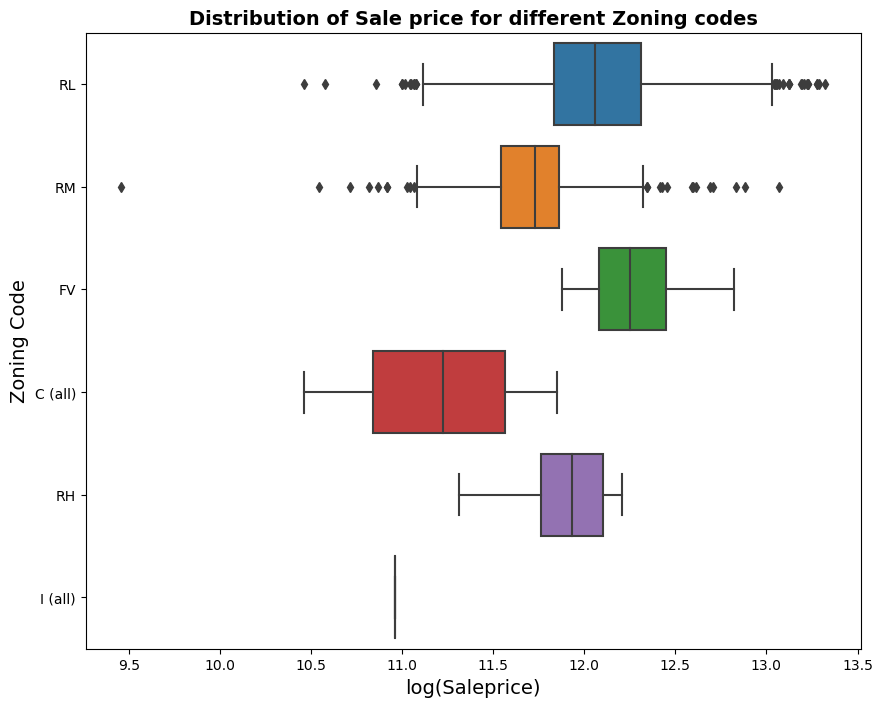

RL         1596
RM          316
FV          101
C (all)      19
RH           14
I (all)       1
Name: MS Zoning, dtype: int64

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_train, x="logprice", y="MS Zoning")
ax.set_xlabel('log(Saleprice)', fontsize=14)
ax.set_ylabel('Zoning Code', fontsize=14)
#ax.set_xlim(0, 6.5e5)  
ax.set_title('Distribution of Sale price for different Zoning codes', fontweight='bold', fontsize=14)
plt.savefig('../figures/zoning_boxplot.png', dpi=300)
plt.show()
df_train['MS Zoning'].value_counts()

Seems like that's definitely worth including. So to sum it all up, we have
1) home quality
2) adjusted living area
3) adjusted garage area
4) year built
5) year remodeled
6) Home Functionality
6) MS zoning

For the numerical columns, does it make sense to fit them against the log of the price? 

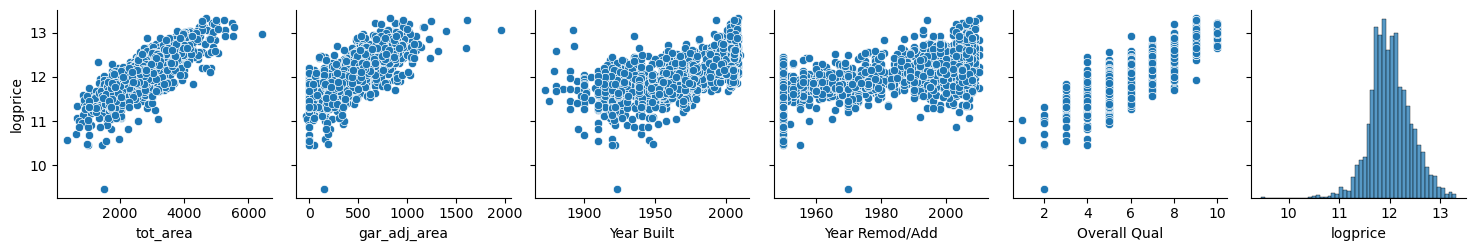

In [36]:
features = ['tot_area', 'gar_adj_area', 'Year Built', 'Year Remod/Add', 'Overall Qual', 'logprice']
sns.pairplot(df_train, x_vars=features, y_vars='logprice')
plt.savefig('../figures/pairplot_m1_logprice.png', dpi=300)

Looks pretty reasonable to me! Those low-price outliers are still annoying, they are much worse in logspace than in linear space. But hopefully the 'Overall Qual', 'Func' and 'Zoning' features can take care of that somewhat.

Sidenote: It might make more sense in the long run to use 'Time since built' or 'Time since remod/add', rather than absolute years. But in this dataset, the actual range of sell dates is not that much (4 years), so for this particular data set it's not really going to matter. If the sale dates covered eg. 10 or more years, that would be worth taking into account.

In [37]:
#dummify zoning columns and home functionality columns
df_train_dummies = pd.get_dummies(df_train, columns=['MS Zoning', 'Func'])
df_train_dummies.drop(columns=['MS Zoning_RL', 'Func_Typ'], inplace=True) #drop baseline (most common occurence)

In [38]:
#Create a dataframe with all my feature-engineered columns, and the target variable, that I can feed directly to the model
features = ['tot_area', 'gar_adj_area', 'Year Built', 'Year Remod/Add', 'Overall Qual']
for col in df_train_dummies.columns:
    if ('MS Zoning' in col) or ('Func_' in col):
        features.append(col)
X = df_train_dummies[features]
features.append('logprice')
y = df_train_dummies['logprice']
df_model = df_train_dummies[features]

## Feature Engineering for model 2

What if we make the model more complicated? From the correlation plot above, we can see that a few other columns have decent correlation with saleprice
'TotRms AbvGrd', 'Full Bath', 'Mas Vnr Area', and 'Fireplaces'. For 'Mas Vnr Area' and 'Fireplaces', we can do something similar as we did with 'Garage Area', and modify these values based on the quality of the fireplaces and the type of veneer.

In [39]:
print(df_train['Fireplaces'].value_counts())

0    998
1    898
2    145
3      5
4      1
Name: Fireplaces, dtype: int64


In [40]:
print(df_train['Fireplace Qu'].value_counts())

NP    998
Gd    521
TA    407
Fa     59
Po     31
Ex     31
Name: Fireplace Qu, dtype: int64


How does fireplace quality affect home sale price?

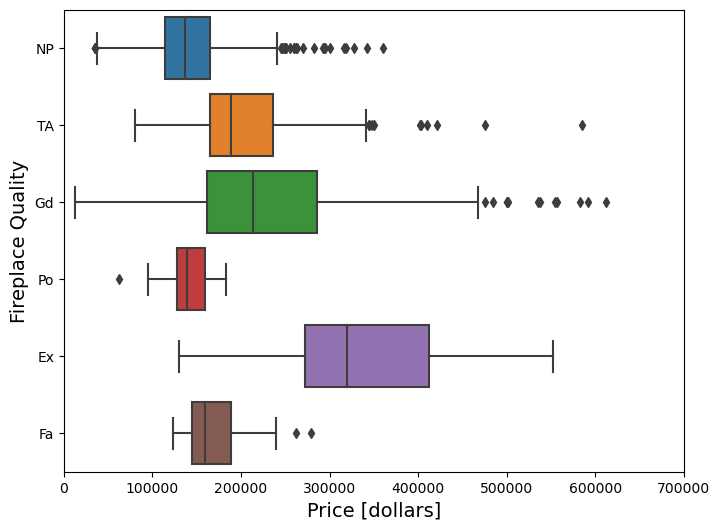

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_train, x="SalePrice", y="Fireplace Qu")
ax.set_xlabel('Price [dollars]', fontsize=14)
ax.set_ylabel('Fireplace Quality', fontsize=14)
ax.set_xlim(0, 7e5)  
plt.show()

In [42]:
df_grouped = df_train.groupby(by="Fireplace Qu")['SalePrice'].mean()
bad_to_good = ['Po', 'NP', 'Fa', 'TA', 'Gd', 'Ex']
df_grouped = df_grouped.reindex(bad_to_good)


Now let's repeat the procedure we did for the garage parameters. Note that the numer fireplaces is an integer, but the 'adjusted fireplaces' will be a float.

In [43]:
df_train_fp = df_train.groupby(by="Fireplace Qu")['SalePrice'].mean()
fp_qual_coefs = (df_train_fp-df_train_fp['NP'])/(df_train_fp['TA'] - df_train_fp['NP'])
print(fp_qual_coefs)

Fireplace Qu
Ex    3.018857
Fa    0.448088
Gd    1.461247
NP    0.000000
Po   -0.046679
TA    1.000000
Name: SalePrice, dtype: float64


In [44]:
adj_fp_l = []
for rowind in df_train.index:
    row = df_train.loc[rowind]
    qual = row['Fireplace Qu']
    adj_fp_l.append(row['Fireplaces'] * fp_qual_coefs[qual]) 

df_train['adj_fireplace']  = adj_fp_l

Let's see if Mas Vnr Type has an affect on the saleprice as well

In [45]:
df_train['Mas Vnr Type'].value_counts()

None       1238
BrkFace     630
Stone       166
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

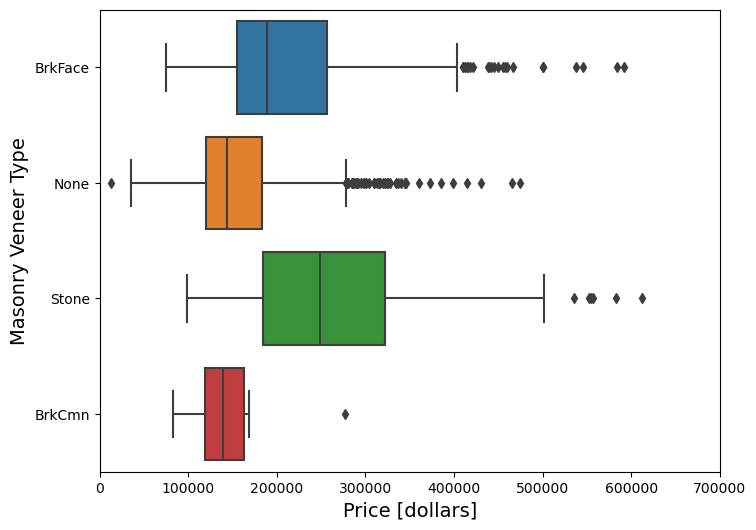

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_train, x="SalePrice", y="Mas Vnr Type")
ax.set_xlabel('Price [dollars]', fontsize=14)
ax.set_ylabel('Masonry Veneer Type', fontsize=14)
ax.set_xlim(0, 7e5)  
plt.show()

In [47]:
df_train_mv = df_train.groupby(by="Mas Vnr Type")['SalePrice'].mean()
mv_qual_coefs = (df_train_mv-df_train_mv['None'])/(df_train_mv['BrkFace'] - df_train_mv['None'])
print(mv_qual_coefs)

Mas Vnr Type
BrkCmn    -0.189556
BrkFace    1.000000
None       0.000000
Stone      1.926016
Name: SalePrice, dtype: float64


In [48]:
adj_mv_l = []
for rowind in df_train.index:
    row = df_train.loc[rowind]
    vtype = row['Mas Vnr Type']
    adj_mv_l.append(row['Mas Vnr Area'] * mv_qual_coefs[vtype]) 

df_train['adj_mas_vnr_area']  = adj_mv_l

What about Neighborhood column? Although this will introduce a lot of extra columns, intuitively it makes sense that neighbourhood would have a big effect on sale price.

In [49]:
print(df_train['Neighborhood'].value_counts())
df_g = df_train.groupby(by='Neighborhood')['SalePrice'].mean()

NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     81
BrkSide     76
Crawfor     71
IDOTRR      68
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker     17
NPkVill     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64


Before we put this all into a new feature engineering function, let's compare the 'adjusted' values for fireplaces and mas vnr area to the unadjusted ones.

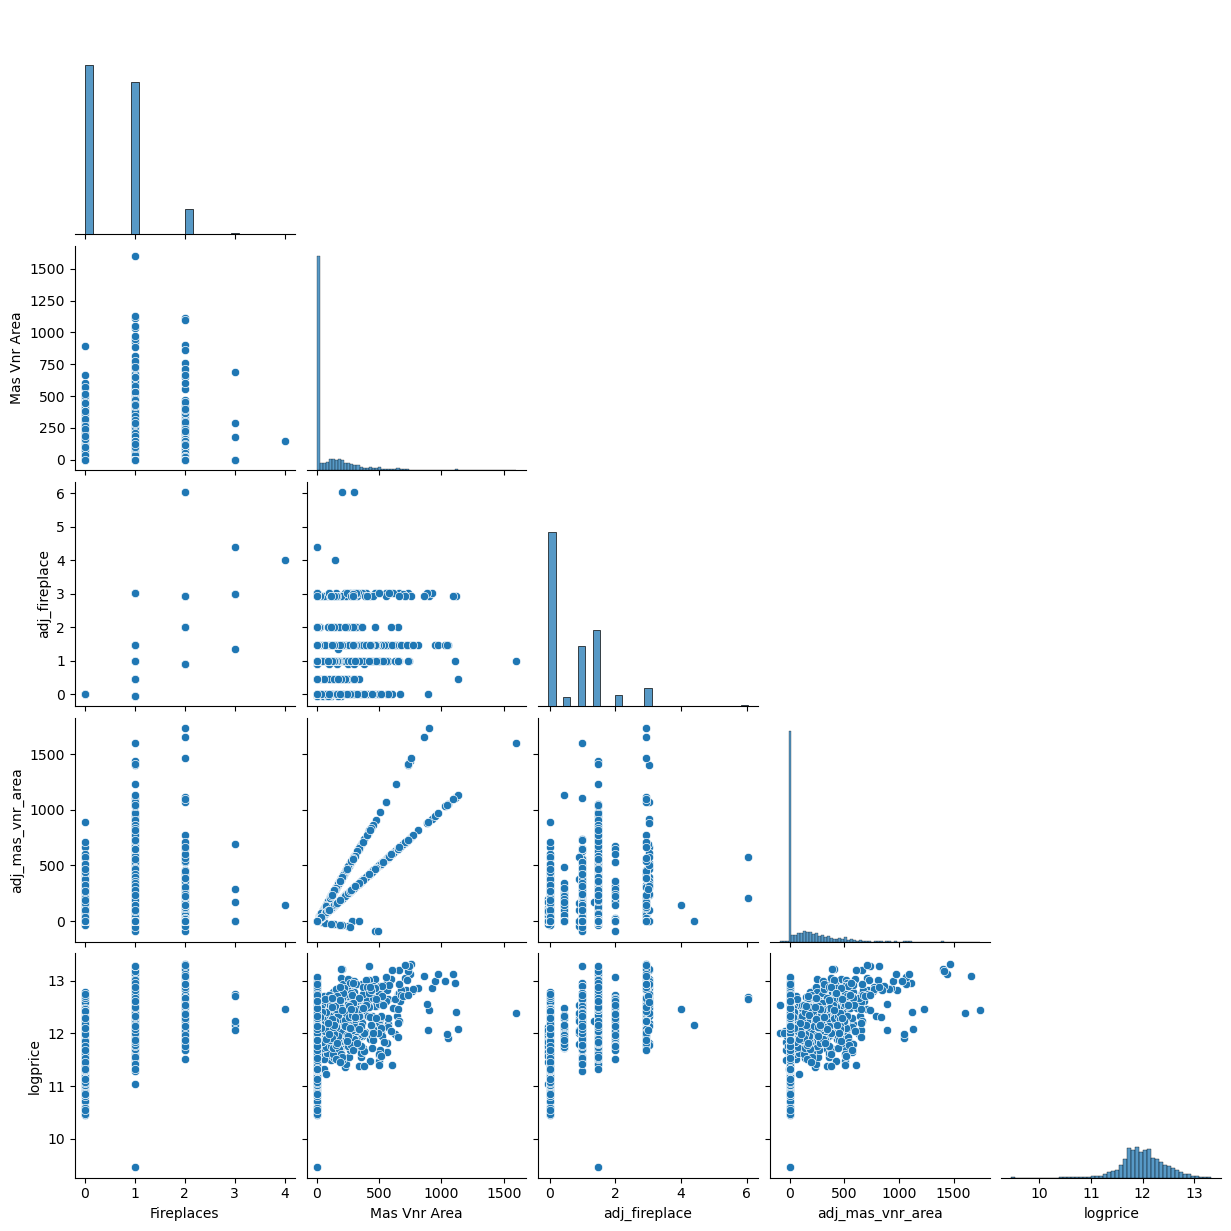

In [50]:
df_train['logprice'] = np.log(df_train['SalePrice'])
features = ['Fireplaces', 'Mas Vnr Area', 'adj_fireplace', 'adj_mas_vnr_area', 'logprice']

sns.pairplot(df_train[features], corner=True);

In [51]:
#Are the correlation coefficients actually better for the original vs the adjusted columns?

print('Correlation coefficient for nr of fireplaces:',df_train['SalePrice'].corr(df_train['Fireplaces']))
print('Correlation coefficient quality of fireplaces:', df_train['SalePrice'].corr(df_train['adj_fireplace']))

Correlation coefficient for nr of fireplaces: 0.4731543691861187
Correlation coefficient quality of fireplaces: 0.5411662000936974


In [52]:
print('Correlation coefficient for Mas Vnr Area:', df_train['SalePrice'].corr(df_train['Mas Vnr Area']))
print('Correlation coefficient for Adjusted vnr area:', df_train['SalePrice'].corr(df_train['adj_mas_vnr_area']))

Correlation coefficient for Mas Vnr Area: 0.5111756845854953
Correlation coefficient for Adjusted vnr area: 0.5564645735356519


Slightly! So we will include them in the more complex model. Let's also plot a correlation between the log of the saleprice and the new numerical features we are adding to the model.

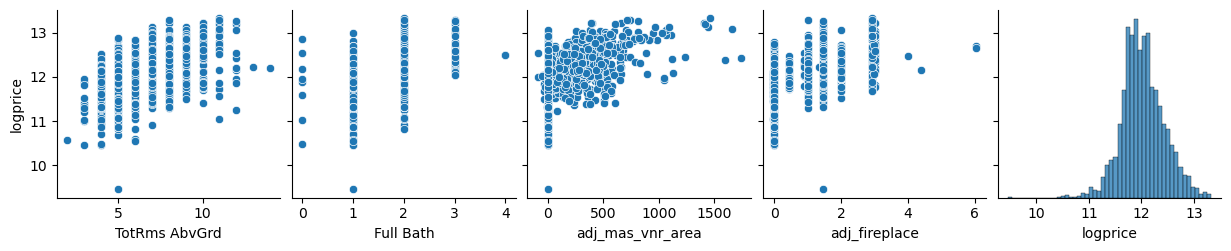

In [53]:
features = ['TotRms AbvGrd', 'Full Bath', 'adj_mas_vnr_area', 'adj_fireplace', 'logprice']
sns.pairplot(df_train, x_vars=features, y_vars='logprice')
plt.savefig('../figures/pairplot_m2_logprice.png', dpi=300)

## Model 3

No additional feature engineering necessary for this model

## Model 4

In the modeling notebook, it seems that Model 3 is actually better than Model 2. Additionally. it looks like the r2 scores for the training and validation data have been very similar, indicating that we are not at the overfitting point yet. It seems that we can still add more features to the model before we reach the overfitting stage.

For numerical columns, we could add 'Lot Frontage' and 'Garage Cars' to the model, as both seem to have a high correlation with sale price. I will also add 'Overall Cond', as while the correlation coefficient seems low, the plot of the overall house condition versus the sale price higher up suggests that it might still add some useful information to the model. 

Are there any other 'object' columns we could include? Let's see if there are any other ones which have very different average sale prices for each category

In [54]:
ign_cols = ['MS Zoning', 'Street', 'Neighborhood', 'Func', 'Functional']
for col in df_train.columns:
    if (col not in ign_cols) and (df_train[col].dtype == 'object') and ('Garage' not in col):
        std = df_train.groupby(by=col)['SalePrice'].mean().std()
        print('Column', col)
        print('Standard deviation of categories', std, '\n')

Column MS SubClass
Standard deviation of categories 40390.01948920862 

Column Alley
Standard deviation of categories 34252.60410389037 

Column Lot Shape
Standard deviation of categories 29736.718582625457 

Column Land Contour
Standard deviation of categories 50497.53680021428 

Column Utilities
Standard deviation of categories 62883.05917602644 

Column Lot Config
Standard deviation of categories 23317.910796297696 

Column Land Slope
Standard deviation of categories 13223.451885150127 

Column Condition 1
Standard deviation of categories 49568.787384256604 

Column Condition 2
Standard deviation of categories 120174.15233432088 

Column Bldg Type
Standard deviation of categories 33683.74485725621 

Column House Style
Standard deviation of categories 41610.786433605834 

Column Roof Style
Standard deviation of categories 33192.450667431214 

Column Roof Matl
Standard deviation of categories 64466.51607098375 

Column Exterior 1st
Standard deviation of categories 56292.74437568976 



In [55]:
print(df_train['Kitchen Qual'].value_counts())
df_train.groupby(by='Kitchen Qual')['SalePrice'].mean()

TA    1046
Gd     806
Ex     149
Fa      46
Name: Kitchen Qual, dtype: int64


Kitchen Qual
Ex    338632.510067
Fa    103253.108696
Gd    211629.451613
TA    139557.058317
Name: SalePrice, dtype: float64

It looks like Kitchen Quality might be a good idea to incorporate in the model as well

Conditions 1 and 2 seem to have a fairly big saleprice difference in their categories. Can we dummify them together?

In [56]:
print(df_train['Condition 1'].value_counts())
print(df_train['Condition 2'].value_counts())

Norm      1765
Feedr      108
Artery      69
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: Condition 1, dtype: int64
Norm      2021
Feedr       11
Artery       5
PosA         3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: Condition 2, dtype: int64


In [57]:
all_conds = df_train['Condition 1'].unique().tolist()
all_conds2 = df_train['Condition 2'].unique().tolist()
print(all_conds, all_conds2)
#Drop Norm from the list - that's the baseline
all_conds.remove('Norm')
#Loop over all conditions, make a dummy column for that condition, and set val to 1 if the condition is in either the condition 1 or 2 columns
#I found this way of using np.where on stackoverflow: https://stackoverflow.com/questions/61550532/dummy-variable-from-two-columns-in-python
for cond in all_conds:
    colname = 'Cond_' + cond
    if cond in all_conds2:
        df_train[colname] = np.where((df_train['Condition 1'] == cond) | (df_train['Condition 2'] == cond), 1, 0)
    else:
        df_train[colname] = np.where((df_train['Condition 1'] == cond), 1, 0)

['RRAe', 'Norm', 'PosA', 'Artery', 'Feedr', 'PosN', 'RRAn', 'RRNe', 'RRNn'] ['Norm', 'RRNn', 'Feedr', 'Artery', 'PosA', 'PosN', 'RRAe', 'RRAn']


Let's also add 'Bsmt Qual', 'Central Air', 'Alley', and 'Paved Drive':

In [58]:
df_train['Central Air'].value_counts()

Y    1907
N     140
Name: Central Air, dtype: int64

In [59]:
df_train['Alley'].value_counts()

NP      1907
Grvl      85
Pave      55
Name: Alley, dtype: int64

In [60]:
df_train['Paved Drive'].value_counts()

Y    1859
N     149
P      39
Name: Paved Drive, dtype: int64

Finally - what about the 'Yr Sold' column? In the EDA we saw that this dataset comprises houses sold between 2006 and 2010. The financial crisis was in 2008, so perhaps we should include a categorical value for year as well?

In [61]:
print(df_train['Yr Sold'].value_counts())
df_train.groupby(by='Yr Sold')['SalePrice'].mean()

2007    497
2009    446
2006    437
2008    433
2010    234
Name: Yr Sold, dtype: int64


Yr Sold
2006    179695.800915
2007    185527.883300
2008    182190.096998
2009    182455.244395
2010    174180.059829
Name: SalePrice, dtype: float64

Although the difference between years is actually surprisingly modest, I still think that housing price increase and decreases typically apply somewhat equally to all houses, and that therefore it could be a good parameter to include. So let's use it as well.

Let's make another pairplot to show the correlation of the new numerical features we are adding to the log of the sale price

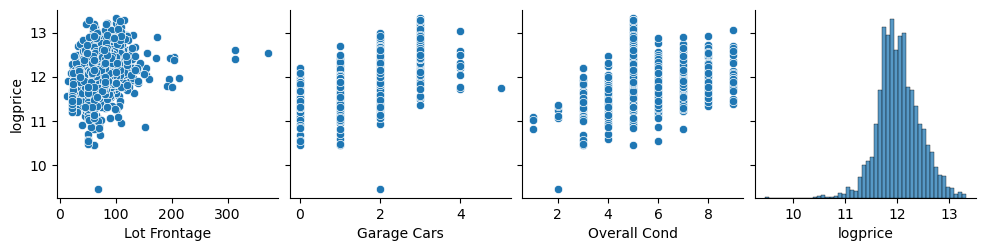

In [62]:
df_train['logprice'] = np.log(df_train['SalePrice'])
features = ['Lot Frontage', 'Garage Cars', 'Overall Cond', 'logprice']
sns.pairplot(df_train, x_vars=features, y_vars='logprice')
plt.savefig('../figures/pairplot_m4_logprice.png', dpi=300)